# Flowers classifier

In this notebook, I used [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


## Load data


In [3]:
# data paths
dir_path = 'flower_photos/'
train_dir = os.path.join(dir_path, 'train/')
test_dir = os.path.join(dir_path, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Datasets

In [4]:
# transforms
transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])
# datasets
trainset = datasets.ImageFolder(train_dir, transform = transform)
testset = datasets.ImageFolder(test_dir, transform = transform)

# print out some data stats
print('Num training images: ', len(trainset))
print('Num test images: ', len(testset))

Num training images:  3130
Num test images:  540


### DataLoaders

In [5]:
batch_size = 20

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)


### Visualize Data

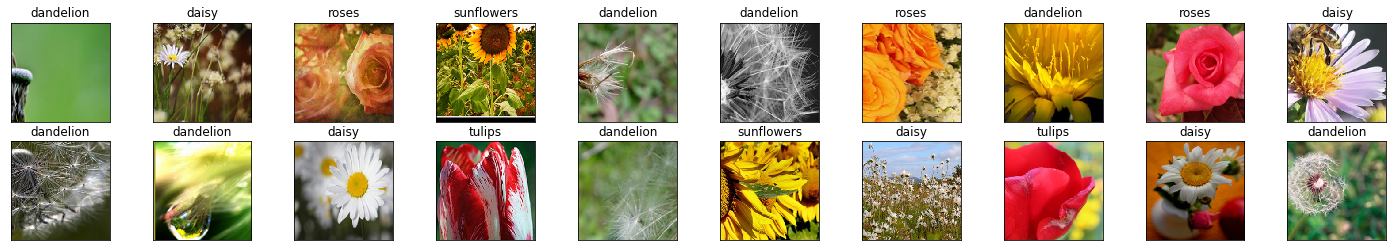

In [6]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [7]:
# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained = True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
print(vgg16.classifier[0])
print(vgg16.classifier[6].in_features)

Linear(in_features=25088, out_features=4096, bias=True)
4096


In [9]:
# Freeze all parameters
for param in vgg16.features.parameters():
    param.requires_grad = False

In [10]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# new layer automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

# add last layer
vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=5, bias=True)


## Training the network

### Loss function and Optimizer

In [11]:
from torch import optim
import torch.nn as nn

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr = learning_rate)

In [12]:
epochs = 2

for epoch in range(epochs):
    train_loss = 0
    for batch_i, (images, labels) in enumerate(trainloader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        output = vgg16(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch_i % 20 == 19:
            print('Epoch: {} \tBatch: {} \tBatch train loss:{:.3}'.format(epoch + 1,
                                                batch_i + 1, train_loss / batch_size))
            train_loss = 0   

Epoch: 1 	Batch: 20 	Batch train loss:1.55
Epoch: 1 	Batch: 40 	Batch train loss:1.35
Epoch: 1 	Batch: 60 	Batch train loss:1.27
Epoch: 1 	Batch: 80 	Batch train loss:1.13
Epoch: 1 	Batch: 100 	Batch train loss:1.03
Epoch: 1 	Batch: 120 	Batch train loss:0.985
Epoch: 1 	Batch: 140 	Batch train loss:0.94
Epoch: 2 	Batch: 20 	Batch train loss:0.846
Epoch: 2 	Batch: 40 	Batch train loss:0.865
Epoch: 2 	Batch: 60 	Batch train loss:0.868
Epoch: 2 	Batch: 80 	Batch train loss:0.794
Epoch: 2 	Batch: 100 	Batch train loss:0.774
Epoch: 2 	Batch: 120 	Batch train loss:0.771
Epoch: 2 	Batch: 140 	Batch train loss:0.715


## Testing

In [13]:
num = len(classes)
class_correct = list(range(num))
class_total = list(range(num))
test_loss = 0
correct_total = 0

vgg16.eval()
for images, labels in testloader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    output = vgg16(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    
    _, pred = torch.max(output, 1)
    correct = pred == labels
    correct_total += (pred == labels).sum().item() 
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
accuracy = correct_total / len(testset)

# prints
for i in range(num):
    print('Test accuract of {}: {:.1%}'.format(classes[i], class_correct[i] / class_total[i]))

print('\nTest loss: {:.3} \tGlobal accuracy: {:.1%}'.format(test_loss/len(testloader), accuracy))   

Test accuract of daisy: 73.9%
Test accuract of dandelion: 94.0%
Test accuract of roses: 59.1%
Test accuract of sunflowers: 65.4%
Test accuract of tulips: 75.8%

Test loss: 0.75 	Global accuracy: 74.6%


### Visualize Sample Test Results

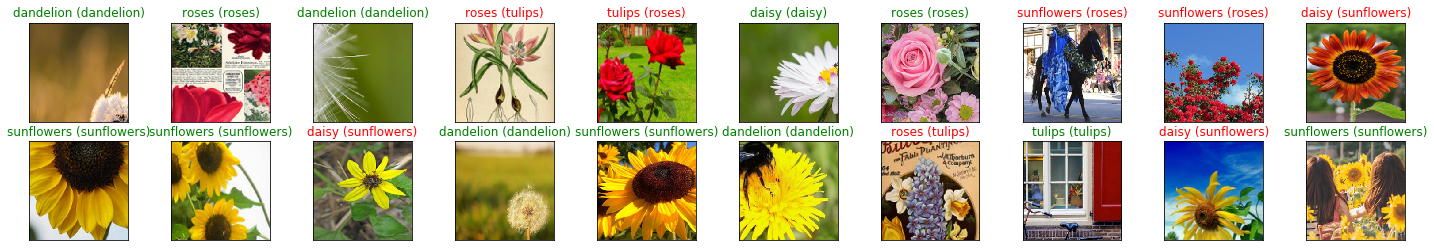

In [14]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))